In [1]:
import numpy as np
import os
import tarfile
import urllib.request
from matplotlib import pyplot as plt
from utils import perfect_matching_vis, plot_tsp_path, download_url
%matplotlib inline

# Warcraft Shortest Path

Download dataset

In [2]:

# warcraft_url = "https://edmond.mpdl.mpg.de/imeji/exportServlet?format=file&id=http://edmond.mpdl.mpg.de/imeji/item/PPjoEvUh9_PVTPSD"
# data_path = "warcraft_shortest_path.tar.gz"
# if not os.path.exists(data_path):
#     print("Downloading dataset...")
#     download_url(warcraft_url, data_path)

# print(f"Extracting {data_path} ...")
# f = tarfile.open(data_path, "r:gz")
# f.extractall(path=".")
# f.close()
# print("Extracted")


For the Warcraft Sortest Path dataset we have randomly genrated maps of different sizes with optimal shortest path from the top left vertex to the bottom right vertex. Each type of tile has a different cost, we also supply the costs used to generate the optimal shortest paths.

Train images shape:  (10000, 96, 96, 3)
Train labels shape:  (10000, 12, 12)
Weights shape: (10000, 12, 12)
Train weights [[1.2 1.2 1.2 1.2 1.2 1.2 1.2 1.2 1.2 0.8 0.8 0.8]
 [1.2 1.2 1.2 1.2 1.2 1.2 1.2 1.2 1.2 1.2 1.2 1.2]
 [1.2 1.2 1.2 1.2 1.2 1.2 1.2 7.7 7.7 7.7 7.7 1.2]
 [1.2 1.2 1.2 1.2 1.2 1.2 1.2 1.2 7.7 7.7 1.2 1.2]
 [0.8 0.8 0.8 0.8 0.8 1.2 1.2 1.2 1.2 1.2 1.2 0.8]
 [5.3 5.3 5.3 5.3 0.8 0.8 1.2 1.2 1.2 1.2 1.2 1.2]
 [5.3 5.3 5.3 5.3 0.8 0.8 1.2 9.2 9.2 9.2 1.2 1.2]
 [5.3 5.3 5.3 5.3 0.8 1.2 1.2 1.2 9.2 9.2 1.2 0.8]
 [5.3 5.3 5.3 5.3 0.8 0.8 0.8 1.2 1.2 1.2 1.2 0.8]
 [5.3 5.3 5.3 5.3 5.3 5.3 0.8 0.8 0.8 0.8 0.8 0.8]
 [5.3 5.3 5.3 5.3 5.3 5.3 5.3 5.3 5.3 5.3 0.8 5.3]
 [5.3 5.3 5.3 5.3 5.3 5.3 5.3 5.3 5.3 5.3 0.8 0.8]]


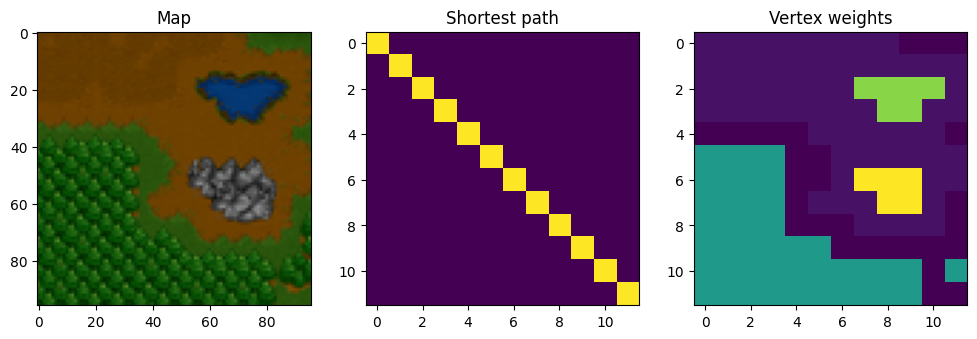

In [3]:
data_dir = 'warcraft_shortest_path/12x12/'

data_suffix = "maps"
train_prefix = "train"


train_inputs = np.load(os.path.join(data_dir, train_prefix + "_" + data_suffix + ".npy"))
train_weights = np.load(os.path.join(data_dir, train_prefix + "_vertex_weights.npy"))
train_labels = np.load(os.path.join(data_dir, train_prefix + "_shortest_paths.npy"))

#images = train_inputs.transpose(0,2,3,1).astype(np.uint8)
images = train_inputs

print("Train images shape: ", train_inputs.shape)
print("Train labels shape: ",  train_labels.shape)
print("Weights shape:", train_weights.shape)

idx = 10
im = images[idx]
label = train_labels[idx]
weights = train_weights[idx]

print("Train weights", weights)


fig, ax = plt.subplots(1,3, figsize=(12,12))

ax[0].imshow(im.astype(np.uint8))
ax[0].set_title("Map")
ax[1].imshow(label)
ax[1].set_title("Shortest path")
ax[2].set_title("Vertex weights")
ax[2].imshow(weights.astype(np.float32))

# MNIST Min-cost Perfect Matching

Download dataset

In [4]:

# os.makedirs("mnist_matching", exist_ok=True)
# mnist_matching_url = "https://edmond.mpdl.mpg.de/imeji/exportServlet?format=file&id=http://edmond.mpdl.mpg.de/imeji/item/HrfrAxcoQ049qk4K"
# data_path = "datasets/perfect_matching.tar.gz"
# if not os.path.exists(data_path):
#     print("Downloading dataset...")
#     download_url(mnist_matching_url, data_path)

# print(f"Extracting {data_path} ...")
# f = tarfile.open(data_path, "r:gz")
# f.extractall(path="mnist_matching")
# f.close()
# print("Extracted")



In [5]:
# data_dir = './mnist_matching/4x4_mnist_nonunique'

# train_prefix = "train"
# data_suffix = "full_images"
# train_inputs = np.load(os.path.join(data_dir, train_prefix + "_" + data_suffix + ".npy"))
# train_labels = np.load(os.path.join(data_dir, train_prefix + "_perfect_matching.npy"))

# images = train_inputs.transpose(0,2,3,1).astype(np.uint8)


# img_idx = 2

# plt.title("Example training data point")
# plt.imshow(images[img_idx][:, :, 0], cmap="gray")


The labels for each datapoint are vectors inidicating each edge that was used in the perfect matching by 0-1 entries. In order to convert this to grid coordinates, the function `edges_from_grid` is useful returning the set of edges as tuples of grid coordinates (y1,x1, y2, x2). The label vector indicates which edges are in the matching from this set, example usage for a grid of dimension 4:

```python
edges = edges_from_grid(4, neighbourhood_fn='4-grid')

```

In [6]:
# plt.title("Edge label vector")
# plt.imshow(train_labels[img_idx][..., None])

In [7]:
# labeled_image = perfect_matching_vis(images[img_idx], 4, train_labels[img_idx], color="#e19c24", width=2)
# plt.imshow(labeled_image)

# Country Capitals Travelling Salesman Problem

Download dataset

In [8]:
# import tarfile
# import urllib.request

# os.makedirs("globe_tsp", exist_ok=True)
# globe_tsp_url = "https://edmond.mpdl.mpg.de/imeji/exportServlet?format=file&id=http://edmond.mpdl.mpg.de/imeji/item/70niNNMFUsmfEyfm"
# data_path = "globe_tsp.tar.gz"
# if not os.path.exists(data_path):
#     print("Downloading dataset...")
#     download_url(globe_tsp_url, data_path)

# print(f"Extracting {data_path} ...")
# f = tarfile.open(data_path, "r:gz")
# f.extractall(path="datasets/globe_tsp")
# f.close()
# print("Extracted")


We've generated random subsets of country capitals from 100 countries. The training dataset contains 10000 instances, each consisting of 10 images of flags as the input and the optimal TSP tour of the corresponding capitals as the label. For each instance it also contains the ground truth distance matrix of the capitals that generate the optimal TSP tour, but the ground truth distance matrix is not used for training.

In [9]:
# run ``python3 -m pip install git+https://github.com/matplotlib/basemap.git``

The dataset

In [10]:
# data_dir = './globe_tsp/10_countries_from_100/'

# train_prefix = "train"


# flag_indices = np.load(os.path.join(data_dir, train_prefix + "_indices.npy"))
# country_names, gps, flags = zip(*np.load(os.path.join(data_dir, "countries.npy"), allow_pickle=True))
# distance_matrices = np.load(os.path.join(data_dir, train_prefix + "_distance_matrices.npy"))
# tsp_tours = np.load(os.path.join(data_dir, train_prefix + "_tsp_tours.npy"))

# print("Flags shape: ", np.array(flags).shape)
# print("Gps shape: ", np.array(gps).shape)
# print("Flag indices shape (indicates which flags are used in an instance): ", np.array(flag_indices).shape)
# print("Distance matrices shape: ", distance_matrices.shape)
# print("TSP tours / labels shape: ",  tsp_tours.shape)




Examples of individual flags and training instances

In [11]:
# fig, ax = plt.subplots(1,3, figsize=(12,12))

# # We have a set of 100 flags with gps data
# flag_idx = 57
# example_flag = flags[flag_idx]
# example_flag_gps = gps[flag_idx]
# example_flag_name = country_names[flag_idx]
# ax[0].imshow(example_flag.astype(np.uint8))
# ax[0].set_title(f"One of 10 flags in input of instance:\n {example_flag_name} at GPS: {example_flag_gps}")

# # Each instance consists of 10 images of flags as the input and the optimal tsp tour 
# # of the corresponding capitals as the label
# idx = 10
# label = tsp_tours[idx]
# distances = distance_matrices[idx]
# flags_indices_in_instance = flag_indices[idx]

# ax[1].set_title("Example TSP tour \n (used as train label)")
# ax[1].imshow(label)
# ax[2].set_title("Ground truth Distance Matrix for instance \n (not used for training)")
# ax[2].imshow(distances.astype(np.float32))


Visualization of the captial locations

In [12]:
# flags_in_instance = np.array(flags)[flags_indices_in_instance]
# gps_in_instance = np.array(gps)[flags_indices_in_instance]

In [13]:
# # Only plots the tour segments that are fully visible, i.e. both countries are visible
# plot_tsp_path(gps_in_instance, flags_in_instance, tsp_tours[idx])